### Prerequisites

+  A fork of the sysidentpy code is needed to get this thing up and running. 

+ Please clone the [code](https://github.com/robotsorcerer/sysidentpy) to the root folder of `robust-design` in your root directory. 

+ We should be good to go.

In [1]:
import copy 
import scipy
import numpy as np
import pandas as pd

import scipy.linalg as sla 
import numpy.linalg as la 
import matplotlib.pyplot as plt

from scipy.linalg import solve_continuous_are as CARE

# Make sure we can import required slycot routine
try:
    from slycot import sg02ad
except ImportError:
    raise print("Can't find slycot module 'sg02ad'")
    
import sys, os 

sys.path.append("..")
sys.path.append("../../sysidentpy")
from utils import *
from dynsys import * 
from identify import * 

from sysidentpy.narmax_base import InformationMatrix
from sysidentpy.model_structure_selection import (FROLS, FROLS2)
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

### Generating a 3-input-1-output sampled data from a car cruise control model

$$
m \dfrac{dv}{dt} = \alpha_n u T (\alpha_n v) - m g C_r sgn(u) - \dfrac{1}{2} \rho C_d A |v| v - mg \sin \theta
$$

where 

+ $v$ is the velocity profile of the vehicle, aka the state;
+ $m$ is the mass of the vehicle;
+ $\alpha_n$ is the effective wheel radius of the vehicle;
+ $T$ is the vehicle's torque, 
    + controlled by the throttle $u$;
+ $C_r$ is the rolling friction coefficient;
+ $C_d$ is the aerodynamic drag constant for a vehicle of area $A$;
+ $\theta$ is the road curvature, modeled as a Wiener process;

This model is adopted from R.M. Murray's Feedback Systems book, section 4.1.


Let $x := v, \, u_1 := u, \, u_2:= \alpha_n$, and $u_3 := \theta$. Then, The state space equation is

\begin{align}
m \dot{x} &= u_2 u_1 T(u_1 x) - mg C_r sgn(u_1) - \dfrac{1}{2} \rho C_d A |x| x - mg \sin u_3  \\
  \dot{x} &= m^{-1} u_2 u_1 T(u_1 x) - g C_r sgn(u_1) - \dfrac{1}{2} m^{-1} \rho C_d A |x| x - g \sin u_3 
\end{align}

The torque $T$ is given by 

$$
T = T_m \left(1-\beta\left(\dfrac{\omega}{\omega_m}-1\right)^2\right)
$$

where $\beta = 0.4, \omega_m = 420$ and $T_m = 190$, so that we have 

$$
T = 190\left(1 - 0.4 \left(\dfrac{39 x}{420}-1\right)^2 \right) = 190 - 76 \left(\dfrac{39 x}{420}-1\right)^2.
$$

The true model used in data collection is given as

\begin{align}
  \dot{x} &= 0.000625 u_1 u_2 T(u_1 x) - 0.098 sgn(u_1) - 0.000312 |x| x - 9.8 \sin u_3 
\end{align}


### Get the profile of car's inputs and acceleratin throughout travel time.

In [2]:
show = False
cruiser = CruiseControlModel(n=1, m=3, d=1)
u, x = cruiser.data_collect(ndata=16000)
u, x = u, np.expand_dims(x, 1)

from os.path import join, expanduser 

if show:
    font = {'weight' : 'bold',
            'size'   : 22}

    T = np.linspace(0, x.size, x.size)

    # show me what you got
    fontdict = {"fontsize":18, "fontweight":"bold"}
    colors = ["red", "purple", "brown", "blue"]
    fig, ax = plt.subplots(1, 2, figsize=(25,9))
    legends = [rf"Car speed $(m/s^2)$", "Gear ratio", "Road curvature (deg)"]
    titles = [rf"Identification Signal: $u_{{ref}}$", rf"Identification Signal: $\alpha_n$", rf"Identification Signal: $\theta$"]
    i = 0
    for idx in [0, 2]: #range(u.shape[0]):
        ax[i].plot(T/100, u[idx], label=rf"$u_{idx+1}$: {legends[idx]}", color=colors[idx], linewidth=6)
        ax[i].legend(loc="best", fontsize=22)
        ax[i].set_xlabel(rf"Time ($\times$ 100 secs)", fontdict=fontdict)
        ax[i].xaxis.set_tick_params(labelsize=24)
        ax[i].yaxis.set_tick_params(labelsize=24)
        ax[i].grid("on")
        ax[i].set_title(titles[idx], fontdict = font)
        i += 1
    ax[1].yaxis.set_ticks([])
    plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "ident_inputs.eps"), dpi=79, facecolor=None)

    plt.figure(figsize=(25,9))
    plt.plot(T/100, x/1000, label=rf"$x(v)$: Car acceleration $(Km/s^2)$", color="blue", linewidth=8)
    plt.xlabel(rf"Time ($\times$ 100 secs)", fontdict=fontdict)
    plt.ylabel(rf"Acceleration (m/s$^2$)", fontdict=fontdict)
    plt.gca().xaxis.set_tick_params(labelsize=24)
    plt.gca().yaxis.set_tick_params(labelsize=24)
    plt.legend(loc="upper right", fontsize=24)
    plt.grid("on")
    plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "ident_output.eps"), dpi=79, facecolor=None)
    plt.show()

u = u.T

### Do a NARMAX Identification from I/O data

In [4]:

ratio = int(0.8*len(u))
x_train, y_train = u[:ratio], x[:ratio]
x_test,  y_test  = u[ratio:], x[ratio:]

xlag, ylag =[1, 1, 1], 1

degree = 3
cruise_func = CruiseControlBasis(xlag, ylag, noise_var=1e-5, degree=degree, ensemble=False)

frols_model = FROLS2(
    order_selection=False,
    n_terms=4,
    n_info_values=4,
    extended_least_squares=False,
    ylag=ylag, xlag=xlag,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=cruise_func
)

# get regression matrix from Cruise Control Model Basis Class
P_matrix = cruise_func.fit(X=x_train, y=y_train)

print("reg_matrix: ", P_matrix.shape)
    
# Estimate the Theta parameters based on calculated Reg. Matrix
frols_model.fit(X=x_train, y=y_train, reg_matrix=P_matrix)
theta = frols_model.theta 
print()

reg_matrix:  (12799, 35)



### Model Evaluation 

In [5]:
# make predictions based on test data
yhat = cruise_func.predict(x_test, y_test[:frols_model.max_lag], frols_model.pivv, frols_model.final_model , 
                            frols_model.xlag, frols_model.ylag, frols_model.max_lag, theta=theta, horizon=None)

rrse = root_relative_squared_error(y_test, yhat)
print('rrse ', rrse)

r = pd.DataFrame(
    results(
        frols_model.final_model, frols_model.theta, frols_model.err,
        frols_model.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
print(r)
# plot_results(y=y_test, yhat = yhat, n=10000)
ee = compute_residues_autocorrelation(y_test, yhat)
# plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
# x1e = compute_cross_correlation(y_test, yhat, x_test[:, 0])
# plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

rrse  0.1545090687254336
         Regressors   Parameters             ERR
0   x2(k-1)^2y(k-1)   6.2517E-02  9.99999925E-01
1  x2(k-1)^2x1(k-1)  -8.2551E-02  2.14842438E-09
2   x2(k-1)y(k-1)^2   5.6493E-10  3.78525426E-10
3    x3(k-1)x1(k-1)   1.5309E-09  3.16806487E-11


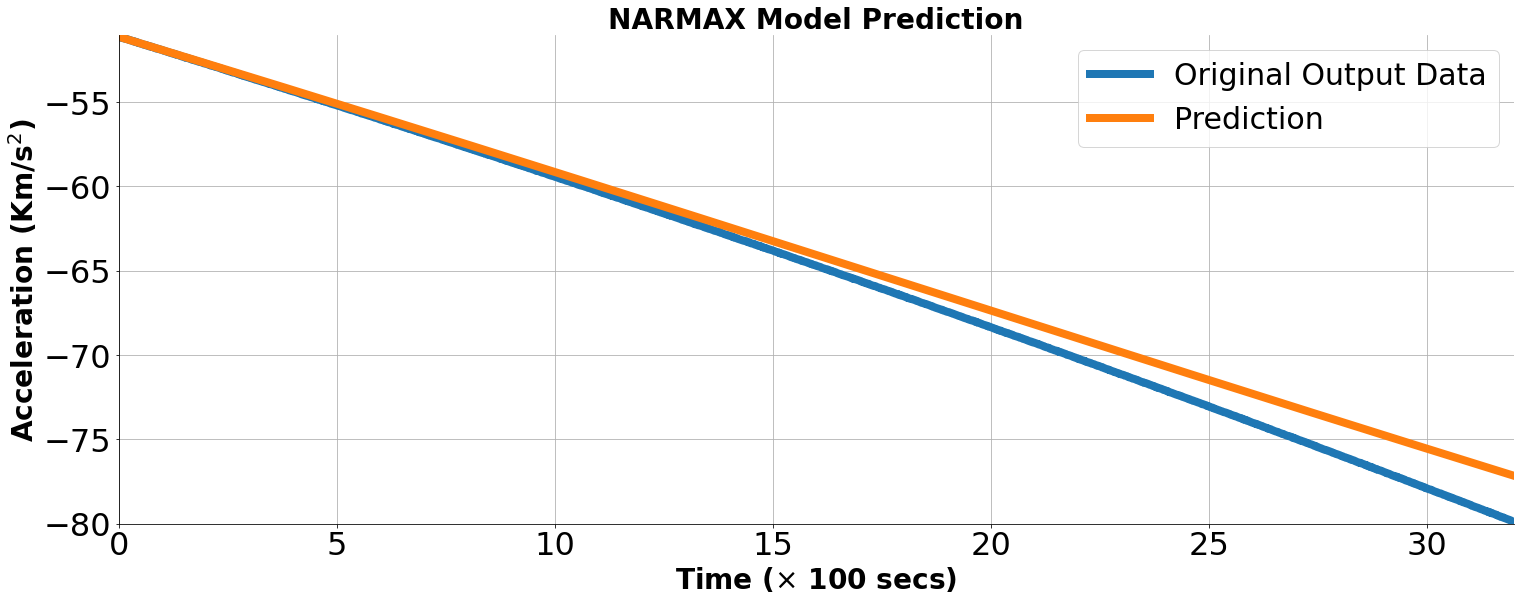

In [6]:
plt.figure(figsize=(25,9),  facecolor="white")
T = np.linspace(0, y_test.size, y_test.size)
fontdict = dict(weight='bold', size=28)

plt.plot(T/100, y_test/1000, label=rf"Original Output Data", color="#1f77b4", linewidth=8)
plt.plot(T/100, yhat/1000, label=rf"Prediction", color="#ff7f0e", linewidth=8)
plt.title("NARMAX Model Prediction", fontdict=fontdict)
plt.xlabel(rf"Time ($\times$ 100 secs)", fontdict=fontdict)
plt.ylabel(rf"Acceleration (Km/s$^2$)", fontdict=fontdict)
plt.ylim([-80, -51])
plt.xlim([0, 32])
plt.gca().xaxis.set_tick_params(labelsize=32)
plt.gca().yaxis.set_tick_params(labelsize=32)
plt.legend(loc="upper right", fontsize=30)
plt.grid("on")
plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "pred.eps"), dpi=79, facecolor=None)
plt.show()


### Plot residues 

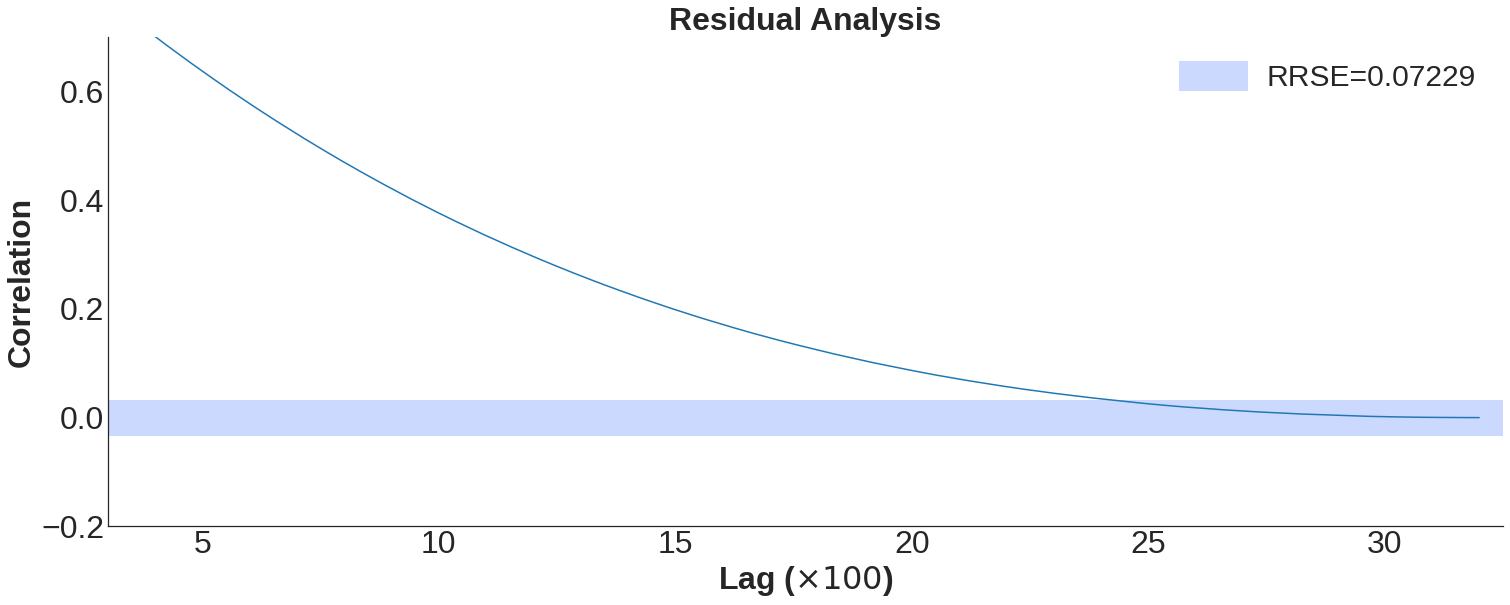

In [7]:

# plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
n=100
style="seaborn-white"
facecolor="white"
title="Residual Analysis"
ylabel="Correlation"
fontdict = dict(weight='bold', size=32)

plt.style.use(style)
plt.rcParams["axes.facecolor"] = facecolor
plt.figure(figsize=(25,9), facecolor="white")
T = np.linspace(0, len(ee[0]), len(ee[0]))
T /= 100
plt.plot(T, ee[0], color="#1f77b4")

ax = plt.gca()
ax.axhspan(ee[1], ee[2], color="#ccd9ff", alpha=1, lw=9, label="RRSE=0.07229")
ax.set_xlabel(rf"Lag ($\times 100$)", fontdict=fontdict)
ax.set_ylabel(ylabel, fontdict=fontdict)
ax.tick_params(labelsize=fontdict["size"])
ax.set_ylim([-0.2, 0.7])
ax.set_xlim([3, 32.5])
plt.legend(loc="upper right", fontsize=30)
ax.set_title(title, fontdict=fontdict)
plt.savefig(join(expanduser("~"),"Documents/Papers/Pubs22/IFAC/figures", "residue.eps"), dpi=79, facecolor=None)
plt.show()


### Find Equilibrium Point

+ Given certain initial conditions in $x_0$, $u_0$ and $z_0$, find all points in the state space that satisfy these equilibrium points 
via multivariate optimization using Powell method. 

In [8]:
import warnings

def narmax_model(x, u, u3=None):
    # print(rf"x: {x} u: {u}, u3: {u3}")
    if len(u)<3:
        u1, u2 = u
    elif len(u)==3:
        u1, u2, u3 = u
    elif len(x) >3:
        x, u1, u2, u3 = x
    if isinstance(x, list): x=x[0]

    result = np.array([6.2518e-02*u2**2 * x -1.2067e-01 * u2**2 * u1 + 5.6692e-10*u2*x**2 + 8.0976e-03*u2**3]).reshape(-1) #squeeze()

    return result
    
def controlled_output(x, u0):
    """Solve the output equation for the H_\infty control problem (eq. 2) 
    in paper.
    """
    if not isinstance(x, np.ndarray): x = np.array(x) 
    if not isinstance(u0, np.ndarray): u0 = np.array(u0)
    C = np.ones((1, x.size))
    D = np.ones((1, u0.size))

    return C@x + D@u0

def find_eq(sys, x0, u0, z0, t=0):
    """
        Find the equilibrium point for an input/output system.

        Returns the value of an equilibrium point given the initial state and
        either input value or desired output value for the equilibrium point.

        Parameters
        ----------
        sys: NARMAX model functor
        x0 : list of initial state values
            Initial guess for the value of the state near the equilibrium point.
        u0 : list of input values, optional
            If `z0` is not specified, sets the equilibrium value of the input.  If
            `z0` is given, provides an initial guess for the value of the input.
            Can be omitted if the system does not have any inputs.
        w0 : list of disturbance values, optional
            If `w0` is not specified, sets the equilibrium value of the input.  If
            `z0` is given, provides an initial guess for the value of the input.
            Can be omitted if the system does not have any inputs.
        z0 : list of output values, optional
            If specified, sets the desired values of the outputs at the
            equilibrium point.
        t : float, optional
            Evaluation time, for time-varying systems
    """

    from scipy.optimize import root

    # Figure out the number of states, inputs, and outputs
    nstates = len(x0)
    ninputs = len(u0)
    noutputs = len(z0)

    # Convert x0, u0, y0 to arrays, if needed
    if np.isscalar(x0):
        x0 = np.ones((nstates,)) * x0
    if np.isscalar(u0):
        u0 = np.ones((ninputs,)) * u0
    # if np.isscalar(w0):
    #     dw = np.random.normal(0, w0, ninputs)
    #     w0 = np.cumsum(dw)
    #     ndisturbs = len(w0)
    if isinstance(z0, list):
        z0 = np.asarray((z0))

    if z0 is None:
        def ode_rhs(z): return sys(z, u, None)
        result = root(narmax_model, x0)
        z = (result.x, u0, controlled_output(result.x, u0))
    else:
        # Take z0 as fixed and minimize over x and u
        def rootfun(z):
            # Split z into x and u
            x, u = np.asarray(([z[0]])), np.asarray(z[1:3]) #, np.asarray(z[3:])

            narm_pred = narmax_model(x, u, u3=None)
            out_pred = controlled_output(x, u)
            print(rf"narm_pred: {narm_pred.shape}, out_pred: {out_pred.shape}, z0: {z0.shape} out-z0: {(out_pred-z0).shape}")

            temp = np.concatenate((narm_pred, out_pred - z0), axis=0)
            print(rf"temp: {temp}, {temp.shape}")

            return temp 

        y0 = np.concatenate((x0, u0) )                # Put variables together
        print(rf"y0: {y0.shape}")
        result = root(rootfun, y0)                      # Find the eq point
        
        x, u = np.split(result.x, [nstates])    # Split result back in two
        z = (x, u, controlled_output(x, u))

    iu = [1,2]
    ix = []
    iz = list(range(noutputs))
    idx = list(range(nstates))

    # Get the states and inputs that were not listed as fixed
    state_vars = (range(nstates) if not len(ix)
                    else np.delete(np.array(range(nstates)), ix))
    input_vars = (range(ninputs) if not len(iu)
                    else np.delete(np.array(range(ninputs)), iu))

    # Set the outputs and derivs that will serve as constraints
    output_vars = np.array(iz)
    deriv_vars = np.array(idx)

    # Verify that the number of degrees of freedom all add up correctly
    num_freedoms = len(state_vars) + len(input_vars)
    num_constraints = len(output_vars) + len(deriv_vars)
    if num_constraints != num_freedoms:
        warnings.warn("Number of constraints (%d) does not match number of degrees "
                "of freedom (%d).  Results may be meaningless." % (num_constraints, num_freedoms))

    # Make copies of the state and input variables to avoid overwriting and convert to floats (in case ints were used for initial conditions)
    x = np.array(x0, dtype=float)
    u = np.array(u0, dtype=float)
    dx0 = np.zeros(x.shape)

    # Keep track of the number of states in the set of free variables
    nstate_vars = len(state_vars)

    def rootfun(z):
        # Map the vector of values into the states and inputs
        x[state_vars] = z[:nstate_vars]
        u[input_vars] = z[nstate_vars:]

        # Compute the update and output maps
        dx = controlled_output(x, u) - dx0

        dy = controlled_output(x, u) - z0

        # Map the results into the constrained variables
        return np.concatenate((dx[deriv_vars], dy[output_vars]), axis=0)

    # Set the initial condition for the root finding algorithm
    z0 = np.concatenate((x[state_vars], u[input_vars]), axis=0)

    # Finally, call the root finding function
    result = root(rootfun, z0)

    # Extract out the results and insert into x and u
    x[state_vars] = result.x[:nstate_vars]
    u[input_vars] = result.x[nstate_vars:]
    z = (x, u, controlled_output(x, u))

    return z + (result,)

In [9]:
# eq_pts = find_eq(narmax_model, [20], [0, 40, 0], z0=[20])#, iu=[1,2])
# print(rf"eq_pts: {eq_pts}")
 
# from math import pi
# import control as ct

# vehicle = ct.NonlinearIOSystem(
#     narmax_model, None, name='vehicle',
#     inputs = ('u', 'gear', 'theta'), outputs = ('v'), states=('v'))


# # Define the time and input vectors
# T = np.linspace(0, 25, 501)
# vref = 20 * np.ones(T.shape)
# gear = 4 * np.ones(T.shape)
# theta0 = np.zeros(T.shape)

# # Find the equilibrium point for the system
# Xeq, Ueq = ct.find_eqpt(
#     vehicle, [vref[0]], [0, gear[0], theta0[0]], y0=[vref[0]], iu=[1, 2])
# print("Xeq = ", Xeq)
# print("Ueq = ", Ueq)    

In [10]:
from math import pi 
import scipy as sp 

# Define the time and input vectors
T = np.linspace(0, 25, 501)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

xeq, ueq, weq = [20], [0.16874874, 40], [0]
theta_hill = [
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T]

# solve for control w/our method here and plot I/O response

### System Response around equilibrium point (no control)


In [33]:
def gamma_lowerbound(A, B1, B2, C, D, K):
    """Compute the starting lower bound for the 
    search for the H infinity norm of a system.
    
    
        See section 4 (Equations 4.3 to 4.4) in the paper below:
    
        @article{BruinsmaSteinbuch,
        title={{A Fast Algorithm to Compute the $H_\infty$-norm of a Transfer Function Matrix}},
        author={Bruinsma, NA and Steinbuch, M},
        journal={Systems \& Control Letters},
        volume={14},
        number={4},
        pages={287--293},
        year={1990},
        publisher={Elsevier}
        };
    """

    # First find omega_p
    poles = sla.eig(A-B1@K)[0]
    if np.any(np.iscomplex(pole)):
        omega_p = max([np.abs(p.imag/p.real)*(1/np.abs(p)) for p in poles])
    else:
        omega_p = min([np.abs(p) for p in poles])

    # G_omega_p = (C - D@K)@la.pinv(1j*omega_p - A + B1@K)@B2
        
    AA = A - B1@K 
    BB = B2
    CC = C-D@K
    Dnew = np.array([[0]])
    sigma_zero = max(compute_sigma(AA, BB, CC, Dnew, 0))
    sigma_omegap = max(compute_sigma(AA, BB, CC, Dnew, omega_p))
    sigma_D = max(la.svd(D, compute_uv = False))

    result = max(sigma_zero, sigma_omegap, sigma_D)

    return result

def get_hinf_norm(A, B1, B2, C, D, K, step_size=0.1):
    """Compute the H infinity norm using Bruinsma's algorithm.

        See section 3.3 in the paper below:
    
        @article{BruinsmaSteinbuch,
        title={{A Fast Algorithm to Compute the $H_\infty$-norm of a Transfer Function Matrix}},
        author={Bruinsma, NA and Steinbuch, M},
        journal={Systems \& Control Letters},
        volume={14},
        number={4},
        pages={287--293},
        year={1990},
        publisher={Elsevier}
        };

        Parameters
        ----------
        A: (array) State transition matrix
        B1: (array) Control matrix
        B2: (array)  Disturbance matrix
        C: (array) Output transmission matrix
        D: (array) Feedthrough matrix
        step_size: (float) degree by which to move up the signal.
    """
    gamma_lb = gamma_lowerbound(A, B1, B2, C, D, K)

    # set gamma_ub to inf
    gamma_ub = np.inf 
    AA = A - B1@K 
    BB = B2
    CC = C-D@K
    while gamma_ub==np.inf:
        gamma = (1+2*step_size)*gamma_lb 

        # get Hamiltonian for this gamma
        Hgamma = hamiltonian(A, B1, B2, C, D, K, gamma)

        # get eigen values of H(gamma)
        eigs = sla.eig(Hgamma)[0]

        if not np.any(np.iscomplex(eigs)):
            gamma_ub = gamma
            break
        else:
            imags = eigs[np.nonzero(np.iscomplex(eigs))]
            gamma_lb_tmp = [np.nan for i in range(len(imags))]
            for i in range(len(imags)-1):
                m_tmp = 0.5*(imags[i]+imags[i+1])
                sigmas_tmp = compute_sigma(AA, BB, CC, 0, m_tmp)
                gamma_lb[i] = max(sigmas_tmp)
            gamma_lb = max(gamma_lb_tmp)

    return 0.5*(gamma_lb + gamma_ub)

def hamiltonian(A, B1, B2, C, D, K, gamma, R=None):
    """Compute the Hamiltonian for a two-player LQ zero sum differential game.
        See equation (15) in my IFAC (2022) paper.

        Parameters
        ----------
        System matrices (arrays) A, B1, B2, C, and D.
        gamma: Robustness parameter for H infinity controller 
        R: Input penalization matrix for the LQ problem. 
            If not provided, it is returned as identity.
            
        Returns
        --------
        H(\gamma): (array) The system's Hamiltonian.
    """
    if not R:
        R = np.eye(K.T.shape[-1])
        
    a11 = A - B1@K
    a12 = -(1/gamma)*B2@B2.T
    a21 = -(1/gamma)*(C.T@C + K.T@R@K)
    a22 = (-A - B1@K).T


    top_row = np.hstack((a11, a12))
    bot_row = np.hstack((a21, a22))

    ham = np.vstack((top_row, bot_row))

    return ham

In [34]:
x0, u0, w0 = [20], [0.16874874, 40], [0, 0]

A, B1, B2, C, D = linearize(x0, u0, w0)

noutputs:  1  C:  (1, 1)


In [35]:

from scipy.signal import place_poles
# pick an hinf norm bound gamma = 0.01

# with eigen placements, generate a series of stabilizing gains
possible_poles = range(-30, -1, 1)
possible_placements = [np.nan for x in range(len(possible_poles))]
Gains = [np.nan for x in range(len(possible_poles))]
Tzw = [np.nan for x in range(len(possible_poles))]

i = 0
for pole in possible_poles:
    possible_placements[i] = np.atleast_1d(np.squeeze(np.asarray(pole)))
    Gains[i] =  place_poles(A, B1, possible_placements[i], method='YT').gain_matrix

    # # for each computed gain, compute the closed loop transfer function over range of frequencies yet to be determined
    Tzw[i] = lambda w: (C - D@Gains[i])@la.pinv(1j*w - A + B1 * K)@B2

    # compute the starting value for gamma_lb
    gamma_ub = get_hinf_norm(A, B1, B2, C, D, Gains[i]) 
    # print(pole, sla.eig(A-B1@Gains[i])[0])
    

    i += 1
# find which of these stabilizing gains simulataneously satisfy the H infinity norm bound for the system before we roll the algo forward


gamma_ub: [162.14417307]
gamma_ub: [167.58778747]
gamma_ub: [173.42023147]
gamma_ub: [179.68470835]
gamma_ub: [186.43106807]
gamma_ub: [193.71713657]
gamma_ub: [201.61037744]
gamma_ub: [210.18998709]
gamma_ub: [219.54956125]
gamma_ub: [229.80052342]
gamma_ub: [241.07658181]
gamma_ub: [253.53959372]
gamma_ub: [267.38738473]
gamma_ub: [282.86432762]
gamma_ub: [300.27588837]
gamma_ub: [320.00899055]
gamma_ub: [342.56110734]
gamma_ub: [368.58278055]
gamma_ub: [398.94139929]
gamma_ub: [434.8197669]
gamma_ub: [477.87380803]
gamma_ub: [530.49541386]
gamma_ub: [596.27242114]
gamma_ub: [680.84285908]
gamma_ub: [793.60344299]
gamma_ub: [951.46826047]
gamma_ub: [1188.26548669]
gamma_ub: [1582.92753039]
gamma_ub: [2372.25161779]


#### Generate Throttle Identification Signal

+ This is a basic sinusoid whose amplitude ranges between 0 and a (amplitude) but corrupted by noise.

In [ ]:
def solve_care(A, B1, B2, Q, R, γ, S=None, E=None, stabilizing=True, method=None, dt=0.0001):
    """
        A Continuous-time (closed-loop) Riccati equation solver for two players 
        in a zero-sum linear quadratic differential game setting.

        Solve the equation 

            :math:`AP +A^T P - P (B_1 R^{-1} B_1^T - \gamma^{-2} B_2 B_2^T) P + Q = 0`

        where A and Q are square matrices of same dimension. In addition, Q is a symmetric 
        positive definite matrix. It returns the solution P, the gain matrices, K and L, as 
        well as the closed-loop eigenvalues of (A - B_1 K + B_2 L), where K and L are the 
        feedback gains of the two players given by 

            :math: `K=R^{-1}B_1^T P,      L = -\gamma^{-2} B_2^T P.`
        
        For details, see the IFAC paper by Lekan Molu and Hosein Hasanbeig.

        Parameters
        ----------
        A, B1, B2, Q : 2D arrays
            Input matrices for the Riccati equation.
        γ : The H infinity risk measure.
        R, S, E : 2D arrays, optional
            Input matrices for generalized Riccati equation.
        method : str, optional
            Set the method used for computing the result.  Current methods are
            'slycot' and 'scipy'.  If set to None (default), try 'slycot' first
            and then 'scipy'.
        dt : float, optional
            Step size of the integration algorithm

        Returns
        -------
        X : 2D array (or matrix)
            Solution to the Ricatti equation
        V : 1D array
            Closed loop eigenvalues
        K : 2D array (or matrix) for minimizing player
        L : 2D array (or matrix) for maximizing player
            Gain matrix

        Notes
        -----
        Author: Lekan Molu
        Date: October 19, 2022
    """

    assert method is not None, "method must be 'slycot' or 'scipy'"


    # Reshape input arrays
    A = np.array(A, ndmin=2)
    B1 = np.array(B1, ndmin=2)
    B2 = np.array(B2, ndmin=2)
    Q = np.array(Q, ndmin=2)
    R = np.eye(B1.shape[1]) if R is None else np.array(R, ndmin=2)
    if S is not None:
        S = np.array(S, ndmin=2)
    if E is not None:
        E = np.array(E, ndmin=2)

    # Determine main dimensions
    n = A.shape[0]
    m = B1.shape[1]

    Rinv = la.inv(R)

    P = np.zeros((n, n))
    # initialization for stopping condition
    P0 = np.ones((n, n))
    step = 0

    while la.norm(P0-P, ord=2)>1e-8 and step < 1e7:
         step += 1
         P0 = copy.copy(P)

         P += (A.T@P0 + P0@A + Q - P0@(B1@Rinv@B1.T - 1/(γ**2)*B2@B2.T)@P0)*dt

    K = Rinv@B1.T@P
    L = 1/(γ**2)*B2.T@P

    return P, K, L

In [ ]:
def system(dt, x, u):
    '''
    Discretized Linear Dynamics of the system dx = (Ax+Bu)dt + Ddw by E-M
    Input:
        dt: time step to 
        x: state of the system, 6 dim
        u: control input of the system, 2 dim
    Output:
        x_next: state at the next step
    '''
    A = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 1)
    A_ = np.array([[12.54, -8.26, -0.39, -0.043, 2.75, -0.36],
                   [-4.38, 36.95, -3.00, 0.086, -9.57, 2.29],
                   [-6.82, -22.94, 11.93, -0.034, 6.82, -2.86]])
    A = np.concatenate((A, A_), axis = 0)
    
    B = np.array([[-50.0, 6.12],
                  [174.4, -38.93],
                  [-124.2, 48.62]])
    B = np.concatenate((np.zeros((3,2)), B), axis = 0)
    
    D = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 0)
    
    xi = np.random.normal(0,1,3)
    x_next = x + (A@x+B@u)*dt + D@xi*np.sqrt(dt)
    
    return x_next


def int_system(dt, tf, x0, K, sigma):
    '''
    Intergrate the sde from 0 to tf
    Input:
        dt: time step to discrete the system
        tf: terminal time of the integral
        x0: initial state
        K: Controller
        sigma: magnitude of exploratory noise
    Output:
        X: state trajectory from 0 to tf
        U: input trajectory from 0 to tf
    '''
    N = int(tf/dt)
    X = np.zeros((N+1,6))
    U = np.zeros((N,2))
    X[0,:] = x0
      
    y = np.zeros(2)
    
    for i in range(N):
        t = i*dt
        y = y - y*dt + np.random.normal(0,1,2)*np.sqrt(dt)
        u = -K@X[i,:] + sigma*y
        x_next = system(dt, X[i,:], u)
        X[i+1,:] = x_next
        U[i,:] = u
        
    return X, U
        

In [ ]:
# run system and collect the data
dt = 0.001
tf = 1500.0
sigma = 10
K_init = np.array([[-257.5,	-96.0,	-39.4,	-85.6,	-37.5,	-19.8],
[-628.4,	-236.7,	-94.1,	-208.6,	-93.3,	-46.7]]) 
# x0 = np.random.normal(0,1,6)
x0 = np.zeros(6)
T = np.arange(0., tf+dt, dt)
X, U = int_system(dt, tf, x0, K_init, sigma)

plt.plot(T, X)
plt.show()

In [ ]:
# Required data matrices for learning algorithm
xn = np.size(X,1) #state dim
un = np.size(U,1) #control dim
wn = 3 #disturbance dim
n_vecv = int((xn+1)*xn/2)
n_phi = n_vecv + xn*un + 1
n_data = len(U) # the total num of data

Phi = np.zeros((n_phi, n_phi))
Xi = np.zeros((n_phi, n_vecv))

for i in range(n_data):
    phi = np.concatenate((vecv(X[i]), 2*np.kron(X[i],U[i])), axis = 0)
    phi = np.concatenate((phi, np.ones(1)), axis = 0)
    Phi += np.outer(phi,phi)*dt
    Xi += np.outer(phi,(vecv(X[i+1])-vecv(X[i])))

Phi = Phi/tf
Xi = Xi/tf    
Phi_inv = np.linalg.pinv(Phi)
        

In [ ]:
A = np.concatenate((np.zeros((3,3)), np.eye(3)), axis = 1)
A_ = np.array([[12.54, -8.26, -0.39, -0.043, 2.75, -0.36],
    [-4.38, 36.95, -3.00, 0.086, -9.57, 2.29],
    [-6.82, -22.94, 11.93, -0.034, 6.82, -2.86]])
A = np.concatenate((A, A_), axis = 0)

B = np.array([[-50.0, 6.12],
    [174.4, -38.93],
    [-124.2, 48.62]])
B = np.concatenate((np.zeros((3,2)), B), axis = 0)


In [ ]:
# Learning-based algorithm
Q = 1*np.eye(xn)
R = np.eye(un)
I = 20 # number of iterations for outer Loop
J = 30 # number of iterations for inner Loop
gamma = 5

D = np.concatenate((np.zeros((3,3)), 1*np.eye(3)), axis = 0)

K = np.array([[-257.5,	-96.0,	-39.4,	-85.6,	-37.5,	-19.8],
[-628.4,	-236.7,	-94.1,	-208.6,	-93.3,	-46.7]])

T_v_vs, T_vs_v  = trans_vec_vecs(xn)
T_vt = Trans_vec(un,xn)

P_storage = np.zeros((I,xn,xn)) #store the P matrices at each iteration
K_storage = np.zeros((I,un,xn)) #store the K matrices

for i in range(I):
    L = np.zeros((wn, xn))
    for j in range(J):
        LD = np.kron(np.eye(xn), np.transpose(L)@np.transpose(D)) + np.kron(np.transpose(L)@np.transpose(D), np.eye(xn))
        LD = T_v_vs@LD@T_vs_v
        KI = T_v_vs@(np.kron(np.eye(xn), np.transpose(K)) + np.kron(np.transpose(K), np.eye(xn))@T_vt)
        Q_KL = Q + np.transpose(K)@R@K - gamma**2*np.transpose(L)@L

        Lambda = Phi_inv[0:n_vecv,:]@Xi - KI@Phi_inv[n_vecv:n_vecv+xn*un,:]@Xi + LD
        P_vecs = -np.linalg.pinv(Lambda)@vecs(Q_KL)
        P = vecs_inv(P_vecs)
        L = gamma**(-2)*np.transpose(D)@P
        
    BP = Phi_inv[n_vecv:n_vecv+xn*un,:]@Xi@P_vecs
    BP = BP.reshape((xn,un))
    K = np.linalg.pinv(R)@np.transpose(BP)

    P_storage[i] = P
    K_storage[i] = K



In [ ]:

#calculate the optimal value
P_opt, K_opt, L_opt = solve_ARE(A, B, D, Q, R, gamma)



In [ ]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

P_norm = np.zeros(I)
K_norm = np.zeros(I)
for i in range(I):
    P_norm[i] = np.linalg.norm(P_storage[i]-P_opt)/np.linalg.norm(P_opt)
    K_norm[i] = np.linalg.norm(K_storage[i]-K_opt)/np.linalg.norm(K_opt)

It = np.linspace(start=0,stop=I,num=I,endpoint=False)
plt.plot(It, P_norm, '*-', linewidth=2.0, markersize=10)
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('${||\hat{P}_{K_i}-P_{*}||}/{||P_{*}||}$', fontsize=18)
plt.show()

plt.plot(It, K_norm, '*-', linewidth=2.0, markersize=12)
plt.xlabel('Iterations', fontsize=18)
plt.ylabel('${||\hat{K}_{i}-K_{*}||}/{||K_{*}||}$', fontsize=18)
plt.show()

In [ ]:
# test the learned controller
sigma = 0.0
x0 = np.random.normal(0,1,6)
T = np.arange(0., 10.0+dt, dt)
X_test, U_test = int_system(dt, 10.0, x0, K, sigma)
plt.plot(T, X_test)
plt.show()

In [ ]:
print(np.linalg.eig(A-B@K))

print(K_opt)